In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from pathlib import Path

In [8]:
ROOT_PATH = Path("dicom-images-train")

data_dir = list(ROOT_PATH.rglob("*/*/*.*"))
labels = pd.read_csv('train-rle.csv')

In [9]:
labels.columns = ['ImageId', 'Target']
labels['Target'][labels['Target'].values != '-1'] = 1
labels['Target'][labels['Target'].values == '-1'] = 0
labels['Target']=labels.Target.astype('int64')

C:\Users\Mx3\AppData\Local\Temp\ipykernel_14904\3007793938.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  labels['Target'][labels['Target'].values != '-1'] = 1
C:\Users\Mx3\AppData\Local\Temp\ipykernel_14904\3007793938.py:3: FutureWarni

In [10]:
# Предобработка данных
def load_dicom_image(filename):
    dicom = pydicom.dcmread(filename)
    image = dicom.pixel_array
    image = np.stack([image] * 3, axis=-1)  # Преобразование в 3 канала
    image = tf.image.resize(image, (128, 128))
    return image / 255.0

In [11]:
# Создание словаря с путями к изображениям
image_paths = {os.path.splitext(os.path.basename(path))[0]: path for path in data_dir}
labels['image_path'] = labels['ImageId'].apply(lambda x: image_paths.get(x, None))
labels = labels.dropna(subset=['image_path'])
labels['image'] = labels['image_path'].apply(load_dicom_image)

In [12]:
#Преобразование данных в массивы
X = np.stack(labels['image'].values).astype(np.float16)
y = labels['Target'].values

In [13]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Создание модели IVGG13
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [18]:
# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1)

324/324 ━━━━━━━━━━━━━━━━━━━━ 761s 2s/step - accuracy: 0.7010 - loss: 0.6593 - val_accuracy: 0.7337 - val_loss: 0.5840


In [22]:
# Оценка модели
y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes)
recall = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

81/81 ━━━━━━━━━━━━━━━━━━━━ 51s 625ms/step
Accuracy: 0.7336935546121188
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


c:\Users\Mx3\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


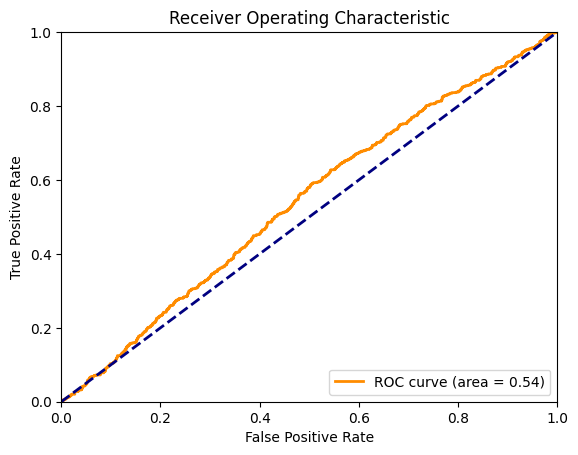

In [23]:
# Построение ROC-кривой
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [24]:
# Выбор оптимального порога
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('Optimal threshold: ', optimal_threshold)

Optimal threshold:  0.22297959
